In [64]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

In [65]:
import pandas as pd

# Read the data
df = pd.read_csv("reviews.csv")
df.shape

(1000, 2)

In [66]:
df.head()

,label,review
0,1,This sound track was beautiful! It paints the ...
1,1,I'm reading a lot of reviews saying that this ...
2,1,This soundtrack is my favorite music of all ti...
3,1,I truly like this soundtrack and I enjoy video...
4,1,"If you've played the game, you know how divine..."


In [67]:
# Check for a class imbalance
df.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

In [68]:
import spacy
nlp = spacy.load("en_core_web_lg")

# Preprocess text, then vectorize it
def preprocess_and_vectorize(text):
    doc = nlp(text)    # create an nlp object out of text

    # Preprocess
    # Take out punctuation, get the lemma of words
    filtered_tokens = []    # create a list for the filtered tokens
    for token in doc:
        if token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)    # append the lemma of the word to the list

    # Vectorize
    # Get mean vector of list of words -- embedding of the entire paragraph
    return wv.get_mean_vector(filtered_tokens)

In [69]:
# Preprocess and vectorize the text entries in the reviews column
# Put the vector embeddings in a new column titled 'vector'
df['vector'] = df['review'].apply(lambda text: preprocess_and_vectorize(text))

In [70]:
df.head()

,label,review,vector
0,1,This sound track was beautiful! It paints the ...,"[0.016545283, 0.012498912, 0.014605034, 0.0473..."
1,1,I'm reading a lot of reviews saying that this ...,"[0.012814509, 0.0052005113, 0.024905888, 0.060..."
2,1,This soundtrack is my favorite music of all ti...,"[0.02028711, 0.015307231, 0.014013072, 0.04956..."
3,1,I truly like this soundtrack and I enjoy video...,"[0.017043907, 0.0034068595, 0.0073494827, 0.04..."
4,1,"If you've played the game, you know how divine...","[0.027132623, 0.0033620065, 0.016174693, 0.039..."


### Train-Test split

In [71]:
from sklearn.model_selection import train_test_split

# Use 20% for testing, 80% for training
X_train, X_test, y_train, y_test = train_test_split(
    df.vector.values,
    df.label,
    test_size=0.2,
    random_state=2022,
    stratify=df.label
)

### Reshape the X_train and X_test to fit for models

In [72]:
import numpy as np

# Create 2D arrays from the train and test datasets
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

### Train Machine Learning Model

In [73]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# 1. Create a GradientBoosting model object
clf = GradientBoostingClassifier()

# 2. Fit with train embeddings
clf.fit(X_train_2d, y_train)

# 3. Get the predictions for the test embeddings
y_pred = clf.predict(X_test_2d)

# 4. Print the classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93       100
           1       0.92      0.94      0.93       100

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



### Make Predictions

In [76]:
test_ai = [
    # AI generated reviews
    "I have to admit, I was genuinely disappointed with this book. The narrative felt incredibly sluggish, as if the author was dragging the story along without any clear direction. The characters lacked depth and failed to evoke any empathy or interest from me. The plot twists, if you can even call them that, were predictable and did little to redeem the overall lackluster storyline. The writing style, too, was unremarkable, lacking the finesse and creativity I expect from a published work. Frankly, I found myself struggling to finish the book, and by the end, I couldn't shake the feeling that I had wasted both time and money on a forgettable piece of literature. Save yourself the trouble and give this one a pass.",
    "Stumbled upon this album, and it's a total vibe! From the first track to the last, it's a musical rollercoaster that hits all the right notes. The artist's style is crazy diverse, giving you tunes for every mood. The lyrics? Pure feels. The vocals? Straight from the heart. It's quickly become my go-to, the soundtrack to my day. If you're into music that's not just background noise but a real mood booster, this album is the one! Highly recommend.",
    "I'm thrilled with this backpack! It nails the sweet spot between style and functionality. The sleek design works for both work and play, and the cleverly organized compartments make it a storage superstar. The laptop sleeve is a game-changer, and the water-resistant material saved my gear in unexpected rain. Plus, it's incredibly comfortable to wear, even on long journeys. The thoughtful details like reflective strips for safety show that this backpack is a cut above the rest. Highly recommended!",
    "This watch is a true gem in my collection. Its elegant design and precision movement make it a standout. The stainless steel case feels sturdy yet lightweight, and the sapphire crystal ensures a scratch-free experience. Comfortable to wear with a versatile strap, it effortlessly transitions from formal to casual occasions. Setting the date and time is a breeze. If you're seeking a blend of style and functionality, this watch is a must-have. Highly recommended!",
    "This captivating journey blends imagination with wisdom. Characters are brilliantly crafted, world-building is enchanting, and the narrative imparts profound insights seamlessly. With perfect pacing and satisfying plot twists, this literary gem transcends genres, leaving a lasting impact. Highly recommended for those seeking a thought-provoking and immersive read.",
    "These shoes are a game-changer! Incredibly comfortable with a sleek design that suits any occasion. Quality craftsmanship, true-to-size fit, and a non-slip sole make them a top pick. Highly recommend for those who want both style and comfort in every step.",
    "These brushes are legit magic. Soft as a kitten's whiskers, they blend makeup like sorcery. Unicorn handles add a whimsical touch. My cat-eye game is now legendary. Packaging is a holographic dream. Transform your face – get these brushes now!",
    "These slippers are an absolute game-changer for anyone in pursuit of comfort. The plush lining feels like a gentle hug for your feet, and the memory foam sole provides heavenly support. The anti-slip bottom ensures stability, even on slippery surfaces. Plus, the design is both cute and functional. Say goodbye to chilly toes – these slippers are a cozy delight!",
    "I had high hopes for these slippers, but sadly, they missed the mark. The memory foam felt more like a thin layer of padding, providing minimal support. The sizing was off, and despite adjusting the straps, the slippers constantly slipped off. The anti-slip bottom didn't live up to its promise – I found myself sliding around on hardwood floors. Disappointing purchase overall; I expected more for the price.",
    "These slippers are middle-of-the-road in terms of comfort and quality. The memory foam provides some cushioning, but it's not as plush as expected. The sizing is accurate, and the anti-slip bottom works well on most surfaces. The design is simple and functional, suitable for everyday wear around the house. While they aren't exceptional, they get the job done for casual use.",
    "This fitness tracker is a handy companion for health enthusiasts. The step count and heart rate monitor are accurate, and the sleep tracking feature provides insightful data. The app interface is user-friendly, making it easy to track progress. My only qualm is that the battery life could be longer; I find myself charging it every few days. Overall, a great tool for fitness tracking and staying motivated on your wellness journey.",
    "I am blown away by the sound quality of this portable Bluetooth speaker! Despite its compact size, it delivers powerful and clear audio. The battery life is impressive, lasting through extended gatherings without needing a recharge. The Bluetooth connectivity is seamless, and I love that it's water-resistant – perfect for poolside parties. If you're in the market for a portable speaker that doesn't compromise on sound, look no further!",
    "This coffee maker changed my mornings forever! The convenience and speed are unmatched. My kitchen feels like a coffee shop now.",
    "This neck pillow is a travel essential. It's like bringing a piece of my own bed with me on long flights. I can finally sleep comfortably on planes!",
    "I can't say enough good things about these resistance bands. They're durable, versatile, and perfect for a full-body workout at home. A game-changer for my fitness routine!"
]

test_real = [
    # Real amazon reviews copied and pasted from product pages
    "How can you not love Reese. Great movie just had to buy it so my wife was happy. Great to watch on cold days to snuggle.",
    "The bag pack arrived on time. First thing I noticed was how good the quality was. The dimensions are perfect for my 5’4” frame. I love that the way that the bag pack opens up and retains that shape. I will be using it for the field. It does not fit my 15” laptop, but it does fit my MacBook Air M2, if that helps. Very very happy with the bag.",
    "It’s structured so you can’t really overfill it which is nice if you have a tendency to do that. Will hold a laptop, notebook or 2 and chargers. Very comfortable to wear and the size makes it easy to take anywhere.",
    "Very nice bag. I purchased so that I could use for work and also as my purse. It’s a nice size and durable. I can be pretty hard on my handbags but this backpack has held up with being thrown around, traveling and all sorts of weather.",
    "This is a beautiful watch/bracelet set. It fits well on my wrist.",
    "This was a birthday gift for our 11 year old daughter and she now goes everywhere with her tortilla blanket! I think it’s the funniest thing and she gets a kick out of it. It’s nice and soft, a very large size, and circular which we really love. The tortilla pattern really makes it fun and my daughter likes to roll up in it and play like she’s a giant burrito. The perfect burrito blanket gift she never knew she wanted.",
    "We were pleasantly surprised with this blanket. It’s soft, big, and nice and thick. It’s now the family favorite and we all fight over it. Good purchase!",
    "This is a really pretty set and the brushes feel lovely. I actually bought them for painting in oils and blending charcoal drawings, so I'm keeping the brushes I'll use and passing the rest of the set to someone who uses makeup. I'll be keeping the brush scrubber - what a handy accessory in a brush set! Very nice packaging and presentation. This would be a nice gift for Secret Santa exchanges.",
    "I was nervous to buy these for the quality cus they were so cheap but they are a perfect UGG dupe!!! They're so comfy and cute for the winter time. Probably gonna buy some more in different colors now haha :)",
    "These are my most favorite, in fact, as I write this, I’m waiting for my second to arrive. They are comfortable, warm, fit perfect. I love them. Although even though people with the reviews have said you can wash them, I would not recommend.. I have tried and they kind of fell apart. I put them through a delicate cycle and air dried and it torn them up. I’m a bit disappointed in that.. so now they are my outdoor shoes if I have to go outside for something. But I highly recommend these. I live in them.",
    "Decent quality except for eyelash curler. The lash curler is a but janky but the rest is surprisingly decent quality. Not the best, but again you get what you pay for. Love the lip scrubber and the lashes are actually really cute and better than expected. Not bad but not professional quality if that’s what you’re looking for",
    "This are great quality, easy to wash and the pouch for the brushes is perfect for travel. My only complain is that the face ones are a LITTLE too soft so it is not great for cream products.",
    "I never thought I'd have this complaint, but the larger brushes are too soft. They're so soft that they don't really have any structure, and therefore there's very little control over what gets deposited or blended. I'm not having very good luck with the eyeshadow brushes either. One positive about the softness of the brushes though: when I'm having a migraine, my husband uses them to softly brush over my face, which feels really really nice. They do feel lovely on the skin, just not the greatest for makeup application. Exfoliators and sponges are top notch though.",
    "These slippers are so comfy and warm! They are so stylish and exactly the look that I wanted. The sole is thick and a harder material so if you wanted to wear it outside you could but I only wear them around my house. I typically wear a size 9 shoe and I ordered a size 10 in these because slippers are usually tight on me for some reason, probably because of the furr. So I always size up and they fit perfectly. They keep me warm now that it is getting cold out and they are all around a great indoor shoe!",
    "Purchased in the beginning of the season to make my range sessions and at home net sessions more purposeful. I have also used with my kids to help them understand flight dynamics, yardage etc. I’ve also used on course with friends. It’s really a great product and I have enjoyed it. With regard to accuracy, it’s great. Just a few range sessions of assessing club yardage has led to better club selection on the course. I’ve lowered my handicap a few strokes and shot a few personal low rounds this year after dialing in yardages. Recently, I had a number on the course and dropped a wedge to tap in distance solely as a result of being better informed. I haven’t scratched the surface of the games and I will likely do so during the winter months. Overall, I would purchase again and I am satisfied with the product."
]

print(f"AI Reviews: {clf.predict([preprocess_and_vectorize(n) for n in test_ai])}")
print(f"Human Reviews: {clf.predict([preprocess_and_vectorize(n) for n in test_real])}")

AI Reviews: [0 0 0 0 0 1 0 0 0 1 0 0 0 0 1]
Human Reviews: [1 1 1 1 1 0 1 1 1 1 1 1 1 1 1]


### Confusion Matrix

Text(95.72222222222221, 0.5, 'Actual Value')

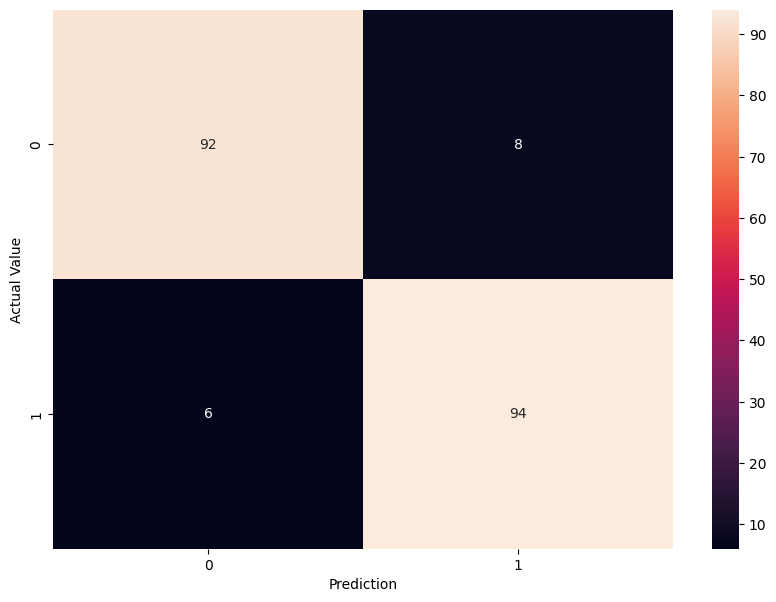

In [75]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
cm

from matplotlib import pyplot as plt
import seaborn as sn
plt.figure(figsize=(10,7))
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prediction')
plt.ylabel('Actual Value')